In [1]:
#read merged investors_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Merged investors.csv")

/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/1601862499.py:6: DtypeWarning: Columns (8,9,11,16,18,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,37,39,40,41,42,47,50,51,52,53,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,100,101,110,111,122,123,124,125,126,130,132,133,134,135,136,147,150,152,155,158,159,160,161,162,163,173,178,183,184,185,186,187,188,191,211,221,232,233,234,235,236,238,239,240,241,242,243,244,245,277,278,279,280,281,282,284,300) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Merged investors.csv")


NameError: name 'p' is not defined

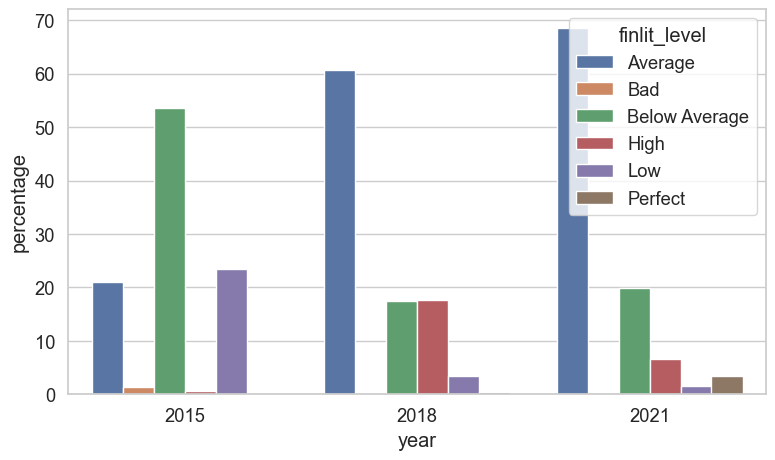

In [3]:
#1.How has financial literacy (FinLit_Level) changed from 2015 to 2021(2015,2018,2021)?
# ===== 1. Prepare data for FinLit_Level distribution =====
df.columns = [c.strip().lower() for c in df.columns]

# Ensure year column exists
if "year" not in df.columns:
    df["year"] = df["nfcsid"].astype(str).str[:4].astype(int)

# Keep only 2015, 2018, 2021 data
df = df[df["year"].isin([2015, 2018, 2021])]
df = df.dropna(subset=["finlit_level"])

# Normalize FinLit_Level labels
df["finlit_level"] = df["finlit_level"].astype(str).str.strip().str.title()

# ===== 2. Compute share of each FinLit_Level per year =====
if "wgt_n2" in df.columns:
    grouped = (
        df.groupby(["year", "finlit_level"], as_index=False)["wgt_n2"]
          .sum()
          .rename(columns={"wgt_n2": "w"})
    )
    grouped["percentage"] = grouped["w"] / grouped.groupby("year")["w"].transform("sum") * 100
else:
    grouped = (
        df.groupby(["year", "finlit_level"], as_index=False)
          .size()
          .rename(columns={"size": "n"})
    )
    grouped["percentage"] = grouped["n"] / grouped.groupby("year")["n"].transform("sum") * 100

# ===== 3. Visualization =====
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(9, 5))
sns.barplot(
    data=grouped.sort_values(["year", "finlit_level"]),
    x="year", y="percentage", hue="finlit_level"
)
p


Rows by year BEFORE dropna:
 year
2015    2000
2018    2003
2021    2824
dtype: int64 

Rows by year AFTER dropna:
 year
2015    2000
2021    2824
dtype: int64 

Unique education labels: ['Less Than High School', 'High School']

2018 missing after drop. Check nulls by component:
2018 edu nulls: 0
2018 conf nulls: 0

Aggregated rows by year:
 year
2015    2000.0
2021    2824.0
Name: n, dtype: float64


/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/2105137980.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q2.groupby(["edu", "year"], as_index=False)
/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/2105137980.py:84: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


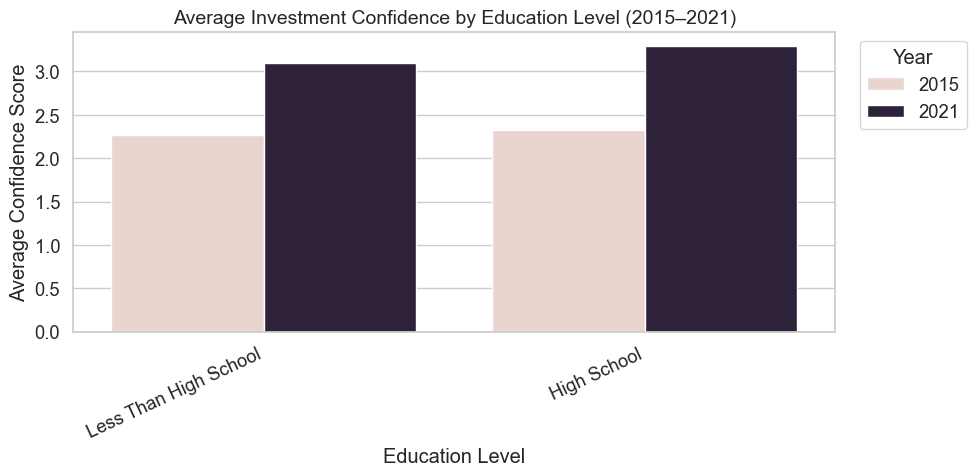

In [11]:
#2.Does education level affect investment confidence?
# ---------- 0) Standardize & year ----------
df.columns = [c.strip().lower() for c in df.columns]
if "year" not in df.columns:
    df["year"] = df["nfcsid"].astype(str).str[:4].astype(int)

# Keep target years
df_q2 = df[df["year"].isin([2015, 2018, 2021])].copy()

# ---------- 1) Unify EDUCATION across variants ----------
edu_candidates = ["education", "s_education", "a4a_new_w"]
present_edu = [c for c in edu_candidates if c in df_q2.columns]
if not present_edu:
    raise ValueError("No education-like column found.")

df_q2["edu_raw"] = df_q2[present_edu].bfill(axis=1).iloc[:, 0]

# Map numeric codes → readable labels (adjust if your codes differ)
code_map = {
    1: "Less Than High School",
    2: "High School",
    3: "Some College",
    4: "Associate Degree",
    5: "Bachelor's Degree",
    6: "Graduate/Professional Degree",
    7: "Other/Unknown",
    98: "Other/Unknown",
    99: "Other/Unknown"
}

# If edu is numeric-like, map; else just clean strings
edu_numeric = pd.to_numeric(df_q2["edu_raw"], errors="coerce")
if edu_numeric.notna().any():
    df_q2["edu"] = edu_numeric.map(code_map)
else:
    df_q2["edu"] = (
        df_q2["edu_raw"].astype(str).str.strip().str.replace(r"\s+", " ", regex=True).str.title()
    )

# Order (will keep only present labels)
edu_order = [
    "Less Than High School", "High School", "Some College",
    "Associate Degree", "Bachelor's Degree", "Graduate/Professional Degree", "Other/Unknown"
]
present_labels = [e for e in edu_order if e in set(df_q2["edu"].dropna())]
df_q2["edu"] = pd.Categorical(df_q2["edu"], categories=present_labels, ordered=True)

# ---------- 2) Unify CONFIDENCE across variants ----------
conf_candidates = [
    "investment confidence_score",
    "investing confidence_score",
    "investment confidence",
    "investing confidence",
    "financial confidence_score"
]
present_conf = [c for c in conf_candidates if c in df_q2.columns]
if not present_conf:
    raise ValueError("No confidence-like column found.")

conf_block = df_q2[present_conf].apply(pd.to_numeric, errors="coerce")
df_q2["conf_num"] = conf_block.bfill(axis=1).iloc[:, 0]

# ---------- 3) Drop missing; quick diagnostics ----------
before_counts = df_q2.groupby("year").size()
df_q2 = df_q2.dropna(subset=["edu", "conf_num"])
after_counts = df_q2.groupby("year").size()

print("Rows by year BEFORE dropna:\n", before_counts, "\n")
print("Rows by year AFTER dropna:\n", after_counts, "\n")
print("Unique education labels:", list(df_q2["edu"].cat.categories))

# If 2018 still missing here, print which side is missing:
if 2018 not in after_counts.index:
    print("\n2018 missing after drop. Check nulls by component:")
    print("2018 edu nulls:", df_q2[df_q2["year"]==2018]["edu"].isna().sum())
    print("2018 conf nulls:", df_q2[df_q2["year"]==2018]["conf_num"].isna().sum())

# ---------- 4) Weighted mean by Education × Year ----------
weight_col = next((w for w in ["wgt_n2", "wgt1", "wgt"] if w in df_q2.columns), None)

if weight_col:
    g = (
        df_q2.groupby(["edu", "year"], as_index=False)
             .apply(lambda x: pd.Series({
                 "mean_conf": (x["conf_num"] * x[weight_col]).sum() / x[weight_col].sum(),
                 "n": len(x)
             }))
             .reset_index(drop=True)
    )
else:
    g = (df_q2.groupby(["edu", "year"], as_index=False)["conf_num"]
                .mean()
                .rename(columns={"conf_num": "mean_conf"}))
    g["n"] = df_q2.groupby(["edu", "year"]).size().values

print("\nAggregated rows by year:\n", g.groupby("year")["n"].sum())

# ---------- 5) Plot ----------
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 5))
sns.barplot(data=g, x="edu", y="mean_conf", hue="year", errorbar=None)
plt.title("Average Investment Confidence by Education Level (2015–2021)", fontsize=14)
plt.xlabel("Education Level"); plt.ylabel("Average Confidence Score")
plt.xticks(rotation=25, ha="right")
plt.legend(title="Year", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()


No usable 'stock share of portfolio' column found—skipping scatter/trend plot.


/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/2547491652.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (yr, rq), grp in q3.groupby(["year", "risk_quartile"]):


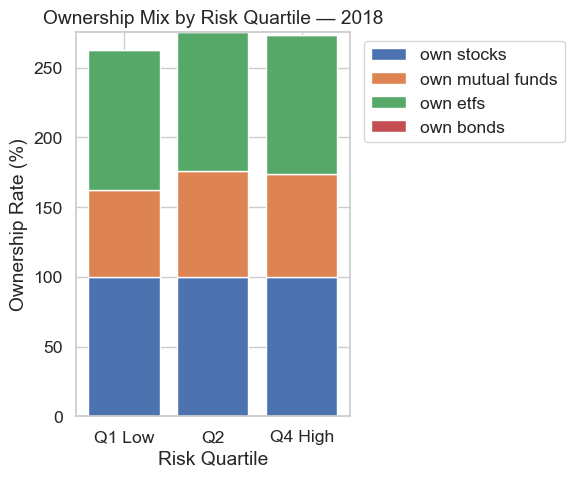

In [14]:
#3.What is the relationship between risk tolerance and portfolio composition?

# Q3 — Relationship between risk tolerance and portfolio composition (2015, 2018, 2021)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.15)

# ---------- 0) Standardize & filter years ----------
df.columns = [c.strip().lower() for c in df.columns]
if "year" not in df.columns:
    df["year"] = df["nfcsid"].astype(str).str[:4].astype(int)
q3 = df[df["year"].isin([2015, 2018, 2021])].copy()

# ---------- 1) Unified RISK TOLERANCE (numeric) ----------
risk_candidates = ["risk_tolerance_score", "risk tolerance_score", "risk_tolerance", "risk tolerance"]
present_risk = [c for c in risk_candidates if c in q3.columns]
if not present_risk:
    raise ValueError("No risk tolerance column found (looked for variants of 'risk tolerance').")

# Try numeric; otherwise map Likert text to numeric
risk_num = pd.to_numeric(q3[present_risk[0]], errors="coerce")
if risk_num.notna().sum() == 0:
    likert_map = {
        "very low": 1, "low": 2, "moderate": 3, "high": 4, "very high": 5,
        "1 - very low": 1, "2 - low": 2, "3 - moderate": 3, "4 - high": 4, "5 - very high": 5
    }
    q3["risk_num"] = q3[present_risk[0]].astype(str).str.strip().str.lower().map(likert_map)
else:
    q3["risk_num"] = risk_num

q3 = q3.dropna(subset=["risk_num"])

# ---------- 2) Portfolio variables ----------
# (A) Continuous: stock share of portfolio (0–100)
share_candidates = ["stock share of portfolio", "stock_share_of_portfolio", "b35"]
present_share = [c for c in share_candidates if c in q3.columns]
q3["stock_share"] = pd.to_numeric(q3[present_share[0]], errors="coerce") if present_share else np.nan

# (B) Ownership flags (binary): Stocks, Mutual Funds, ETFs, Bonds (coalesce variants)
own_maps = {
    "own stocks": ["own stocks", "own_stocks", "individual stocks", "b2_1"],
    "own mutual funds": ["own mutual funds", "own_mutualfunds", "mutual funds", "b2_2"],
    "own etfs": ["own etfs", "own_etfs", "etfs", "b2_3"],
    "own bonds": ["own bonds", "bonds", "b2_4"],
}
def coalesce_binary(df_sub, candidates):
    cols = [c for c in candidates if c in df_sub.columns]
    if not cols:
        return pd.Series(np.nan, index=df_sub.index)
    block = df_sub[cols].copy()
    for c in block.columns:
        block[c] = block[c].map({"Yes":1, "No":0, "Y":1, "N":0, 1:1, 0:0}).astype("float64")
    return block.bfill(axis=1).iloc[:, 0]

for newcol, cands in own_maps.items():
    q3[newcol] = coalesce_binary(q3, cands)

# ---------- 3) Robust risk quartiles (handles ties) ----------
labels = ["Q1 Low", "Q2", "Q3", "Q4 High"]
try:
    q3["risk_quartile"] = pd.qcut(q3["risk_num"], q=4, labels=labels, duplicates="drop")
    if getattr(q3["risk_quartile"], "cat", None) and q3["risk_quartile"].cat.categories.size < 4:
        raise ValueError("Fewer than 4 bins; fallback to percentile ranks.")
except Exception:
    r = q3["risk_num"].rank(pct=True, method="average")
    q3["risk_quartile"] = pd.cut(r, bins=[0, 0.25, 0.50, 0.75, 1.0], labels=labels, include_lowest=True)

# ---------- 4) Scatter + trend: risk vs stock share ----------
weight_col = next((w for w in ["wgt_n2", "wgt1", "wgt"] if w in q3.columns), None)

if q3["stock_share"].notna().sum() > 0:
    plt.figure(figsize=(9, 5))
    sns.scatterplot(data=q3, x="risk_num", y="stock_share", hue="year", alpha=0.22, edgecolor=None)

    # Smooth trend via bin-wise (weighted) means
    bins = np.linspace(q3["risk_num"].min(), q3["risk_num"].max(), 11)
    q3["risk_bin"] = pd.cut(q3["risk_num"], bins=bins, include_lowest=True)
    if weight_col:
        trend = (q3.dropna(subset=["stock_share"])
                   .groupby(["year", "risk_bin"], as_index=False)
                   .apply(lambda x: pd.Series({
                       "risk_mid": x["risk_num"].mean(),
                       "share_mean": (x["stock_share"] * x[weight_col]).sum() / x[weight_col].sum()
                   }))
                   .reset_index(drop=True))
    else:
        trend = (q3.dropna(subset=["stock_share"])
                   .groupby(["year", "risk_bin"], as_index=False)
                   .agg(risk_mid=("risk_num", "mean"), share_mean=("stock_share", "mean")))

    for yr, d in trend.groupby("year"):
        plt.plot(d["risk_mid"], d["share_mean"], marker="o", linewidth=2, label=f"{yr}")

    plt.title("Risk Tolerance vs. Stock Share of Portfolio")
    plt.xlabel("Risk Tolerance (numeric)")
    plt.ylabel("Stock Share of Portfolio (%)")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()
else:
    print("No usable 'stock share of portfolio' column found—skipping scatter/trend plot.")

# ---------- 5) Stacked bars: ownership mix by risk quartile & year ----------
assets = [c for c in ["own stocks", "own mutual funds", "own etfs", "own bonds"] if c in q3.columns]
if assets:
    def weighted_rate(x, col, w=None):
        if w and w in x.columns:
            wsum = x[w].sum()
            return np.nan if wsum == 0 else (x[col] * x[w]).sum() / wsum
        return x[col].mean()

    rows = []
    for (yr, rq), grp in q3.groupby(["year", "risk_quartile"]):
        if grp.empty:
            continue
        entry = {"year": yr, "risk_quartile": rq}
        for a in assets:
            entry[a] = weighted_rate(grp.dropna(subset=[a]), a, weight_col)
        rows.append(entry)

    mix = pd.DataFrame(rows)
    if not mix.empty:
        mix_pct = mix.copy()
        mix_pct[assets] = mix_pct[assets].fillna(0).values * 100

        years_available = sorted(mix_pct["year"].unique())
        ncols = len(years_available)
        fig, axes = plt.subplots(1, ncols, figsize=(6 * ncols, 5), sharey=True)
        if ncols == 1: axes = [axes]

        for ax, yr in zip(axes, years_available):
            m = mix_pct[mix_pct["year"] == yr].sort_values("risk_quartile")
            bottoms = np.zeros(len(m))
            for a in assets:
                ax.bar(m["risk_quartile"].astype(str), m[a], bottom=bottoms, label=a)
                bottoms += m[a].to_numpy()
            ax.set_title(f"Ownership Mix by Risk Quartile — {yr}")
            ax.set_xlabel("Risk Quartile"); ax.set_ylabel("Ownership Rate (%)")
            ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
        plt.tight_layout(); plt.show()
    else:
        print("No data available for ownership mix by risk quartile.")
else:
    print("Ownership columns not found (looked for: own stocks / own mutual funds / own etfs / own bonds).")

In [33]:
# =========================================================
# Shared helpers (run once)
# =========================================================
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, re
sns.set(style="whitegrid", font_scale=1.12)

# 0) normalize columns + ensure 'year'
df = df.copy()
df.columns = [c.strip().lower() for c in df.columns]
if "year" not in df.columns:
    if "nfcsid" in df.columns:
        df["year"] = df["nfcsid"].astype(str).str[:4].astype(int)
    else:
        raise ValueError("No 'year' and no 'nfcsid' found to derive year.")

# 1) utilities
def pick_first(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def to_numeric_scale(s: pd.Series) -> pd.Series:
    """Make survey-like columns numeric (numbers, '7 - strongly agree', Likert words)."""
    num = pd.to_numeric(s, errors="coerce")
    if num.notna().any():
        return num
    # extract number
    s1 = s.astype(str).str.extract(r"([-+]?\d*\.?\d+)")[0]
    s1 = pd.to_numeric(s1, errors="coerce")
    if s1.notna().any():
        return s1
    # Likert keywords (broad)
    t = s.astype(str).str.strip().str.lower()
    pairs = [
        (r"not at all|none at all|strongly disagree", 1),
        (r"a little|slightly|disagree\b", 2),
        (r"somewhat|some\b", 3),
        (r"moderate|neither agree nor disagree|neutral", 4),
        (r"quite|somewhat agree", 5),
        (r"\bvery\b|agree(?!.*strongly)", 6),
        (r"extremely|a great deal|strongly agree|completely", 7),
    ]
    def map_kw(x):
        for pat,v in pairs:
            if re.search(pat, x):
                return float(v)
        return np.nan
    return t.map(map_kw)

def weight_name(dfcols):
    return pick_first(dfcols, ["wgt_n2","wgt1","wgt_s3","wgt","weight"])

WCOL = weight_name(df.columns)

def wmean(x: pd.DataFrame, col: str) -> float:
    if WCOL and WCOL in x.columns and np.nansum(x[WCOL].values) > 0:
        return float(np.nansum(x[col]*x[WCOL]) / np.nansum(x[WCOL]))
    return float(np.nanmean(x[col]))

# 2) Age parsing (works for codes 1–6, numeric ages, or text ranges)
def to_age_group(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    # codes 1–6
    code = {"1":"18–24","2":"25–34","3":"35–44","4":"45–54","5":"55–64","6":"65+"}
    out = s.replace(code)
    # numeric binning
    num = pd.to_numeric(s, errors="coerce")
    bins = [0,24,34,44,54,64,200]
    labels = ["18–24","25–34","35–44","45–54","55–64","65+"]
    out.loc[num.notna()] = pd.cut(num[num.notna()], bins=bins, labels=labels, include_lowest=True).astype(str).values
    # textual ranges
    low = s.str.lower()
    map_rx = {
        r"18\s*-\s*24|18–24|18 to 24": "18–24",
        r"25\s*-\s*34|25–34|25 to 34": "25–34",
        r"35\s*-\s*44|35–44|35 to 44": "35–44",
        r"45\s*-\s*54|45–54|45 to 54": "45–54",
        r"55\s*-\s*64|55–64|55 to 64": "55–64",
        r"65\+|65 and over|65 or older|65 years or older": "65+",
    }
    for rx,lab in map_rx.items():
        out.loc[low.str.contains(rx, regex=True, na=False)] = lab
    # clean category order
    order = ["18–24","25–34","35–44","45–54","55–64","65+"]
    out = pd.Categorical(out, categories=order, ordered=True)
    return out

# 3) small plotting helper
def finish_legend(title="Year"):
    plt.legend(title=title, bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()


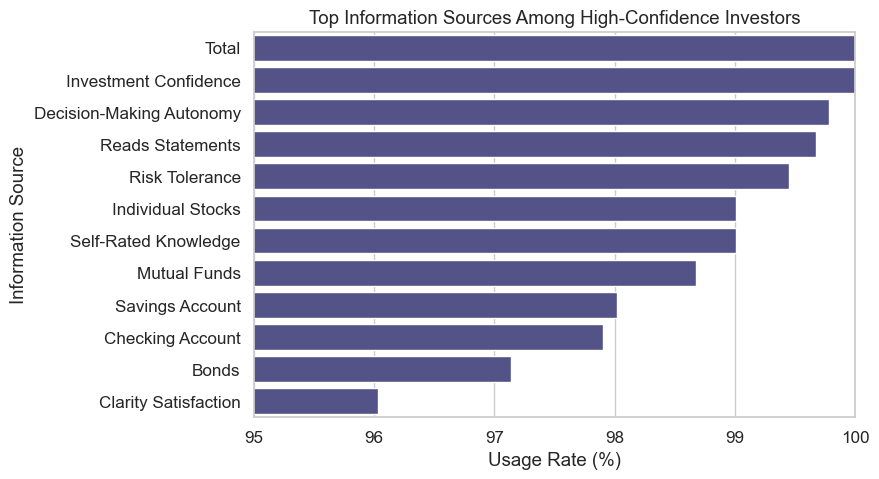

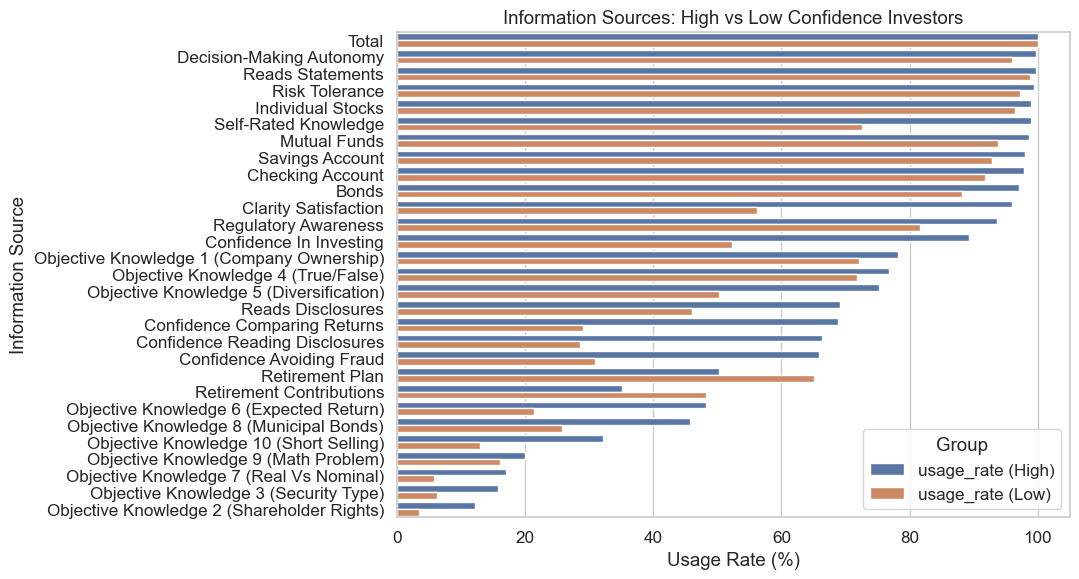

In [ ]:
#4.Which information sources are most used by confident investors?


# drop sources where usage_rate is NaN or zero
high_use = high_use.dropna(subset=["usage_rate"])
high_use = high_use[high_use["usage_rate"] > 0]

low_use = low_use.dropna(subset=["usage_rate"])
low_use = low_use[low_use["usage_rate"] > 0]

# ---- (1) High-confidence investors only ----
plt.figure(figsize=(9, 5))
sns.barplot(data=high_use.sort_values("usage_rate", ascending=False).head(12),
            x="usage_rate", y="source", color="#4B4A91")
plt.title("Top Information Sources Among High-Confidence Investors")
plt.xlabel("Usage Rate (%)")
plt.ylabel("Information Source")
plt.xlim(95, 100)        # zoom in to show fine differences
plt.tight_layout()
plt.show()

# ---- (2) Comparison: High vs Low ----
cmp = high_use.merge(low_use, on="source", suffixes=(" (High)"," (Low)"))
cmp = cmp.melt(id_vars="source", var_name="Group", value_name="Usage Rate (%)")

plt.figure(figsize=(11, 6))
sns.barplot(data=cmp.sort_values("Usage Rate (%)", ascending=False),
            x="Usage Rate (%)", y="source", hue="Group")
plt.title("Information Sources: High vs Low Confidence Investors")
plt.xlabel("Usage Rate (%)")
plt.ylabel("Information Source")
plt.tight_layout()
plt.show()



Chosen pair: investing confidence_score → long-term focus_score | years=(np.int64(2021),) | n=2824


/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/123766063.py:110: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_by_year2 = sub2.groupby("year").apply(lambda x: x[drv].corr(x["behavior_index"])).round(2)


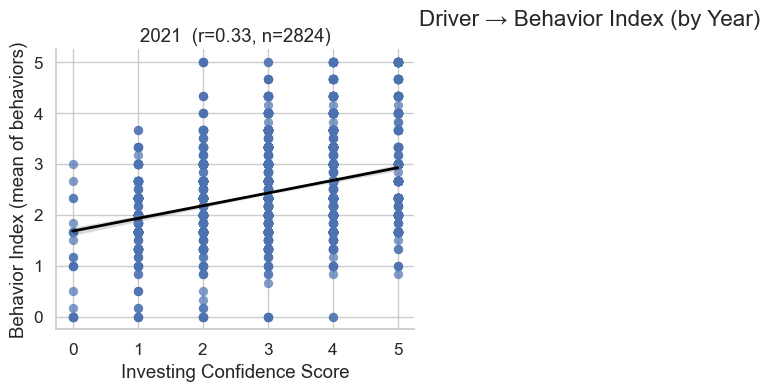

In [ ]:
#5.How do market confidence and risk perception relate to long-term investment behavior?

sns.set(style="whitegrid", font_scale=1.12)

# ---- 1) Prepare frame ----
d = df.copy()  # assumes your merged investors df is already in `df`
d.columns = [str(c).strip().lower() for c in d.columns]

if "year" not in d.columns and "nfcsid" in d.columns:
    d["year"] = d["nfcsid"].astype(str).str[:4].astype(int)

def to_num(x):
    return pd.to_numeric(x, errors="coerce")

# ---- 2) Candidate columns (lowercase; include spaces as in your headers) ----
market_like = [
    "market_confidence_longterm_score",
    "market confidence longterm_score",
    "market_confidence_longterm",
    "investment confidence_score",
    "investing confidence_score",
    "confidence in investing_score",
]
risk_like = [
    "risk_perception_knowledge_score",
    "risk tolerance_score",
    "risk_tolerance_score",
    "stock_vs_bond_knowledge_score",
    "financial_knowledge_truefalse_score",
    "stock_ownership_knowledge_score",
]
behaviors = [
    "long-term focus_score",
    "stay calm during downturns_score",
    "avoid panic selling_score",
    "monitor investments regularly_score",
    "diversify portfolio_score",
    "save consistently_score",
]

market_like = [c for c in market_like if c in d.columns]
risk_like   = [c for c in risk_like   if c in d.columns]
behaviors   = [c for c in behaviors   if c in d.columns]

if not behaviors:
    raise ValueError("No behavior *_score columns found for Q7.")

for c in set(market_like + risk_like + behaviors):
    d[c] = to_num(d[c])

# ---- 3) Helper to pick the best overlapping pair ----
def pick_pair(drivers, targets, min_years=2, min_n=100):
    """
    Return (driver, target, sub_df, meta) where sub_df has non-null overlap.
    First try pairs with data in >= min_years; if none, relax to 1 year.
    Pick the pair with the largest N.
    """
    best = None
    # pass 1: require >= min_years
    for drv in drivers:
        if drv not in d.columns: 
            continue
        for tgt in targets:
            if tgt not in d.columns: 
                continue
            sub = d[[drv, tgt, "year"]].dropna()
            yrs = sub["year"].nunique()
            if len(sub) >= min_n and yrs >= min_years:
                rec = (drv, tgt, sub, {"n": len(sub), "years": tuple(sorted(sub["year"].unique()))})
                if best is None or rec[3]["n"] > best[3]["n"]:
                    best = rec
    if best is not None:
        return best
    # pass 2: relax to >= 1 year
    for drv in drivers:
        if drv not in d.columns: 
            continue
        for tgt in targets:
            if tgt not in d.columns: 
                continue
            sub = d[[drv, tgt, "year"]].dropna()
            if len(sub) >= min_n:
                rec = (drv, tgt, sub, {"n": len(sub), "years": tuple(sorted(sub["year"].unique()))})
                if best is None or rec[3]["n"] > best[3]["n"]:
                    best = rec
    return best

# Prefer a market-confidence driver first; if not, try risk-like
chosen = pick_pair(market_like, behaviors, min_years=2, min_n=50)
if chosen is None:
    chosen = pick_pair(risk_like, behaviors, min_years=2, min_n=50)

if chosen is None:
    raise ValueError("Could not find any driver→behavior pair with enough overlap. "
                     "Try lowering min_n or check which columns exist in each year.")

drv, tgt, sub, meta = chosen
print(f"Chosen pair: {drv} → {tgt} | years={meta['years']} | n={meta['n']}")


# ---- 4）Behavior Index vs driver (same driver), faceted ----
beh_cols_present = [c for c in behaviors if c in sub.columns or c in d.columns]
if len(beh_cols_present) >= 2:
    d["behavior_index"] = d[beh_cols_present].mean(axis=1)
    sub2 = d[[drv, "behavior_index", "year"]].dropna()
    if not sub2.empty:
        g2 = sns.FacetGrid(sub2, col="year", col_wrap=3, height=4, sharex=True, sharey=True)
        g2.map_dataframe(sns.scatterplot, x=drv, y="behavior_index", alpha=0.7, s=45, linewidth=0)
        g2.map_dataframe(sns.regplot, x=drv, y="behavior_index", scatter=False, color="black", line_kws=dict(lw=2))
        r_by_year2 = sub2.groupby("year").apply(lambda x: x[drv].corr(x["behavior_index"])).round(2)
        n_by_year2 = sub2.groupby("year").size()
        for ax, yr in zip(g2.axes.flatten(), sorted(sub2["year"].unique())):
            r = r_by_year2.get(yr, np.nan)
            n = int(n_by_year2.get(yr, 0))
            ax.set_title(f"{yr}  (r={r}, n={n})")
        g2.set_axis_labels(drv.replace("_"," ").title(), "Behavior Index (mean of behaviors)")
        plt.subplots_adjust(top=0.88)
        g2.fig.suptitle("Driver → Behavior Index (by Year)")
        plt.show()



/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/366679390.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc, y=gcol, x="score", palette="Blues_r")
/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/366679390.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


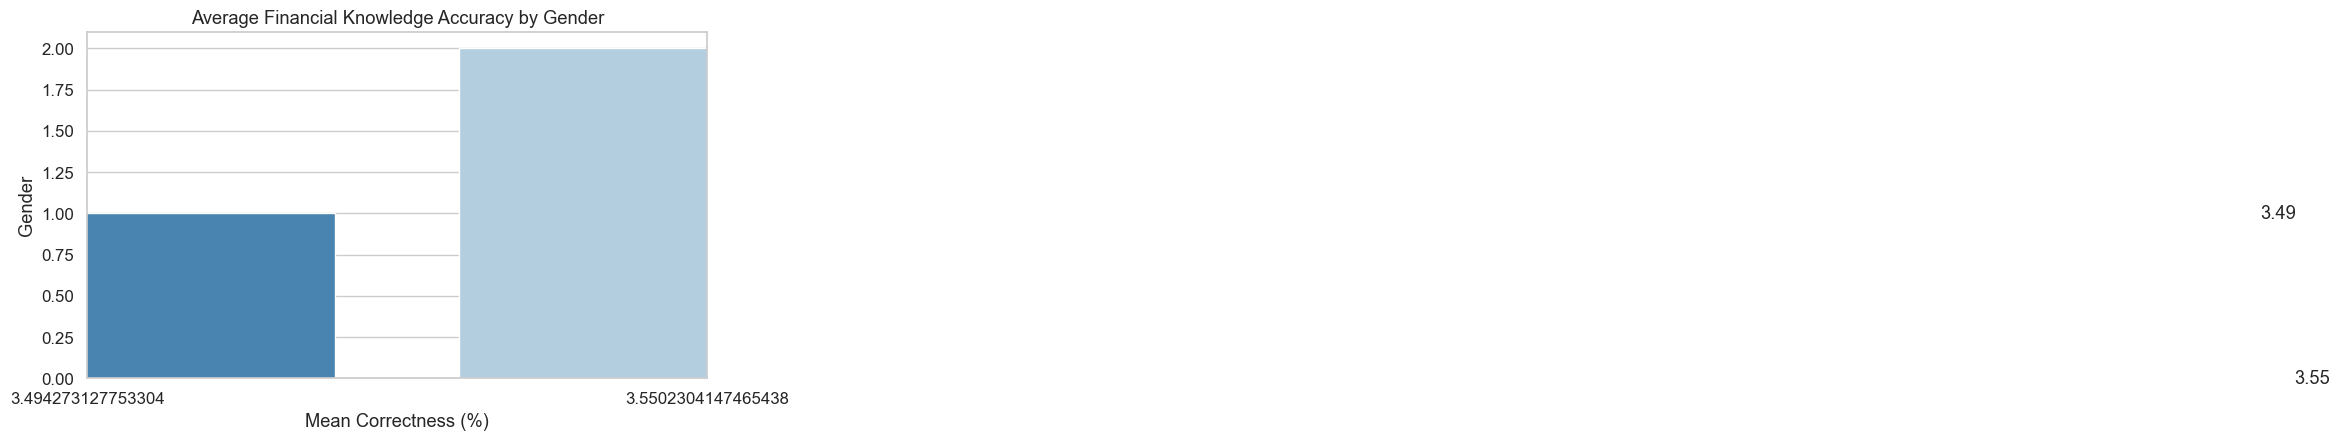

/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/366679390.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc, y=gcol, x="score", palette="Blues_r")
/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/366679390.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


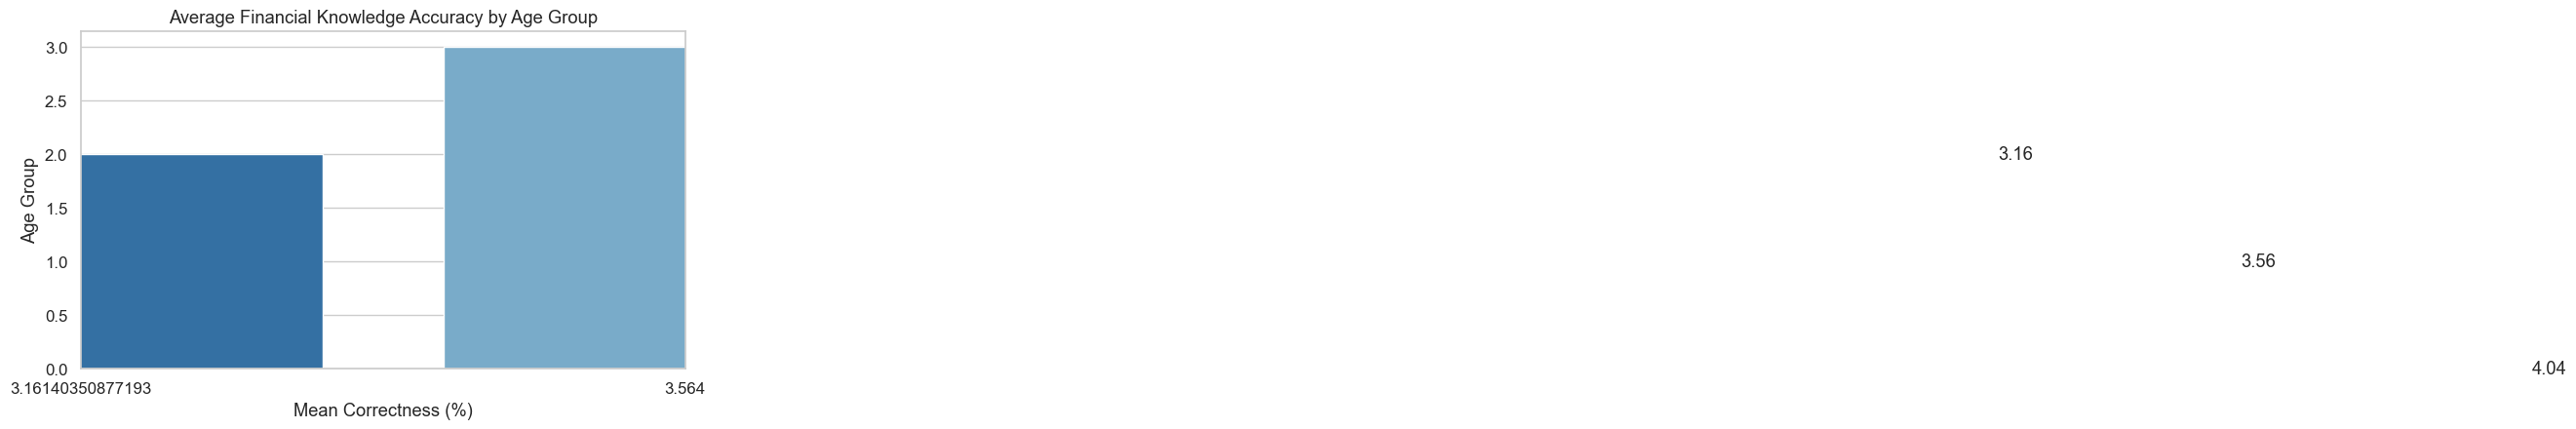

/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/366679390.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc, y=gcol, x="score", palette="Blues_r")
/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_31587/366679390.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


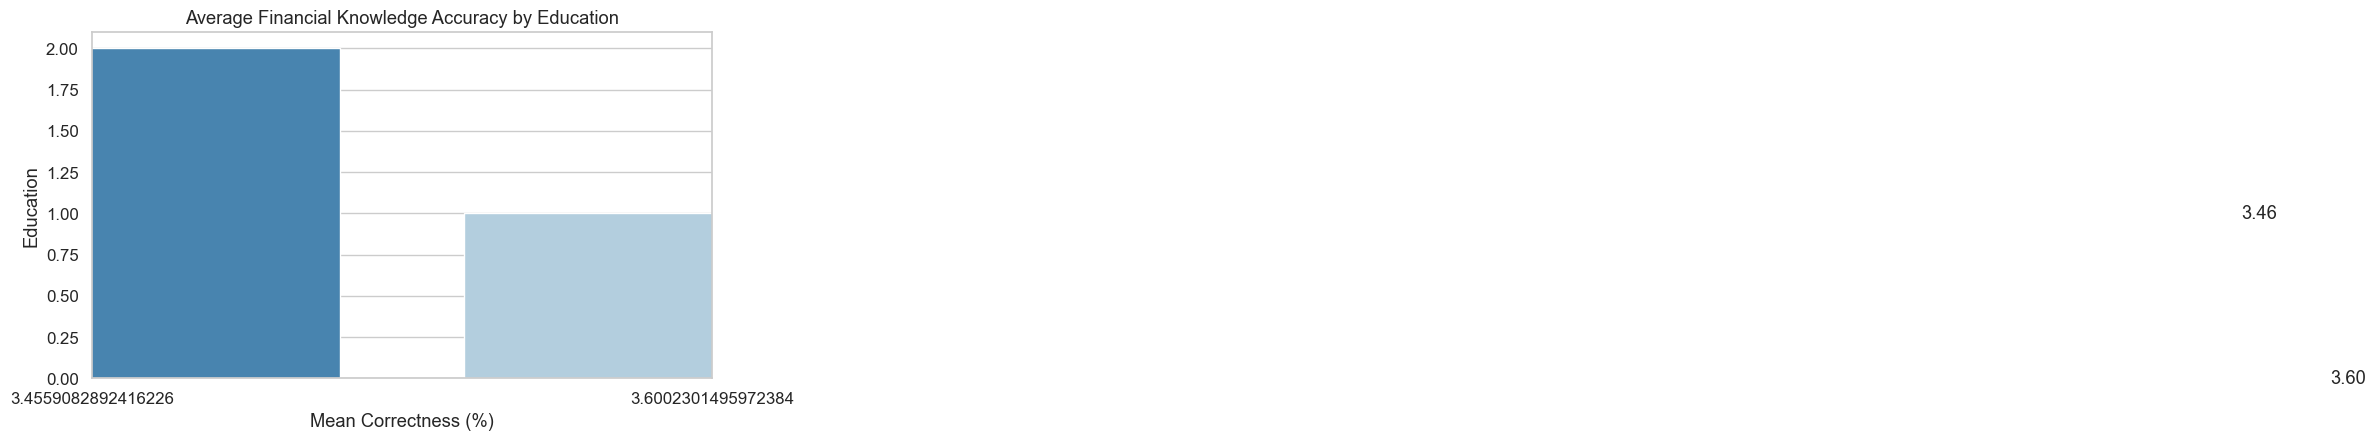

Top-performing demographic segments by knowledge accuracy:
  • Gender: 2.0 (355.0%)
  • Age Group: 1.0 (404.5%)
  • Education: 1.0 (360.0%)


In [ ]:
#6.Which demographic groups have the highest financial knowledge accuracy?
sns.set(style="whitegrid", font_scale=1.1)

# ---- 1) Prepare frame ----
d = df.copy()
d.columns = [str(c).strip().lower() for c in d.columns]

# Add year column if missing
if "year" not in d.columns and "nfcsid" in d.columns:
    d["year"] = d["nfcsid"].astype(str).str[:4].astype(int)

def to_num(x):
    return pd.to_numeric(x, errors="coerce")

# ---- 2) Identify demographic & knowledge columns ----
demo_cols = [c for c in ["gender", "age group", "education", "income group", "race", "marital status"] if c in d.columns]

knowledge_cols = [c for c in d.columns if "financial_knowledge_truefalse" in c or "objective knowledge" in c or "knowledge_score" in c]
if not knowledge_cols:
    raise ValueError("No knowledge accuracy columns found. Try checking your column names.")

# numeric conversion
for c in knowledge_cols:
    d[c] = to_num(d[c])

# ---- 3) Compute mean accuracy by demographic ----
def group_accuracy(df, group_col):
    sub = df[[group_col] + knowledge_cols].copy()
    sub = sub.melt(id_vars=group_col, var_name="question", value_name="score")
    return (sub.groupby(group_col, dropna=True)["score"]
                .mean()
                .reset_index()
                .sort_values("score", ascending=False))

# ---- 4) Plot each demographic group’s accuracy ----
for gcol in demo_cols:
    acc = group_accuracy(d, gcol)
    if acc.empty:
        continue
    plt.figure(figsize=(8, 4.5))
    sns.barplot(data=acc, y=gcol, x="score", palette="Blues_r")
    plt.title(f"Average Financial Knowledge Accuracy by {gcol.title()}")
    plt.xlabel("Mean Correctness (%)")
    plt.ylabel(gcol.title())
    plt.xlim(0, 1)  # assuming scores are proportions 0–1
    for i, val in enumerate(acc["score"]):
        plt.text(val + 0.01, i, f"{val:.2f}", va="center")
    plt.tight_layout()
    plt.show()

# ---- 5) Combined top groups summary (optional) ----
summary = []
for gcol in demo_cols:
    acc = group_accuracy(d, gcol)
    if not acc.empty:
        top = acc.iloc[0]
        summary.append((gcol, top[gcol], round(top["score"], 3)))

if summary:
    print("Top-performing demographic segments by knowledge accuracy:")
    for g, name, val in summary:
        print(f"  • {g.title()}: {name} ({val*100:.1f}%)")
